In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pickle.load(open('/content/drive/MyDrive/dataset_level2.pkl','rb'))

In [ ]:
df

# batting_team
# bowling_team
# city
# current_score
# balls left
# wickets left
# curr rr
# runs in last five overs



,match_id,batting_team,bowling_team,ball,runs,player_dismissed,city,venue
0,5,New Zealand,South Africa,0.1,0,0,Durban,Kingsmead
1,5,New Zealand,South Africa,0.2,0,0,Durban,Kingsmead
2,5,New Zealand,South Africa,0.3,1,0,Durban,Kingsmead
3,5,New Zealand,South Africa,0.4,0,0,Durban,Kingsmead
4,5,New Zealand,South Africa,0.5,0,0,Durban,Kingsmead
...,...,...,...,...,...,...,...,...
116,964,South Africa,Australia,19.2,1,0,Port Elizabeth,St George's Park
117,964,South Africa,Australia,19.3,4,0,Port Elizabeth,St George's Park
118,964,South Africa,Australia,19.4,1,0,Port Elizabeth,St George's Park
119,964,South Africa,Australia,19.5,1,0,Port Elizabeth,St George's Park


In [ ]:
df.isna().sum()

match_id               0
batting_team           0
bowling_team           0
ball                   0
runs                   0
player_dismissed       0
city                8671
venue                  0
dtype: int64

In [ ]:
df[df['city'].isna()]['venue'].value_counts()

Dubai International Cricket Stadium        3092
Pallekele International Cricket Stadium    2066
Melbourne Cricket Ground                   1453
Sydney Cricket Ground                       749
Adelaide Oval                               498
Harare Sports Club                          372
Sharjah Cricket Stadium                     249
Sylhet International Cricket Stadium        128
Carrara Oval                                 64
Name: venue, dtype: int64

In [ ]:
cities=np.where(df['city'].isnull(),df['venue'].str.split().apply(lambda x: x[0]),df['city'])

In [ ]:
df['city'] = cities

In [ ]:
df.isnull().sum()

In [ ]:
df.drop(columns=['venue'],inplace=True)

In [ ]:
eligible_cities = df['city'].value_counts()[df['city'].value_counts() > 600].index.tolist()

In [ ]:
df = df[df['city'].isin(eligible_cities)]

In [ ]:
df


In [ ]:
df['current_score'] = df.groupby('match_id').cumsum()['runs']

In [ ]:
df['over'] = df['ball'].apply(lambda x:str(x).split(".")[0])

df['ball_no'] = df['ball'].apply(lambda x:str(x).split(".")[1])

In [ ]:
df['balls_bowled'] = (df['over'].astype('int')*6) + df['ball_no'].astype('int')

In [ ]:
df['balls_left'] = 120 - df['balls_bowled']
df['balls_left'] = df['balls_left'].apply(lambda x: 0 if x<0 else x)

In [ ]:
df['player_dismissed'] = df['player_dismissed'].apply(lambda x:0 if x=='0' else 1)
df['player_dismissed'] = df['player_dismissed'].astype('int')
df['player_dismissed'] = df.groupby('match_id').cumsum()['player_dismissed']
df['wickets_left'] = 10-df['player_dismissed']


In [ ]:
df['crr'] = (df['current_score']*6)/df['balls_bowled']

In [ ]:
groups = df.groupby('match_id')

match_ids = df['match_id'].unique()

last_five=[]

for id in match_ids:
  last_five.extend(groups.get_group(id).rolling(window=30).sum()['runs'].values.tolist())



In [ ]:
df['last_five'] = last_five

In [ ]:
final_df = df.groupby('match_id').sum()['runs'].reset_index().merge(df,on='match_id')

In [ ]:
final_df=final_df[['batting_team','bowling_team','city','current_score','balls_left','wickets_left','crr','last_five','runs_x']]

In [ ]:
final_df.dropna(inplace=True)

In [ ]:
final_df.isnull().sum()

In [ ]:
final_df=final_df.sample(final_df.shape[0]) # bayas??

In [ ]:
final_df # runs x is output

In [ ]:
pickle.dump(final_df,open('featureset_level1.pkl','wb'))

In [4]:
features = pickle.load(open('/content/drive/MyDrive/featureset_level1.pkl','rb'))

In [5]:
features

,batting_team,bowling_team,city,current_score,balls_left,wickets_left,crr,last_five,runs_x
7664,India,Pakistan,Durban,124,16,3,7.153846,41.0,141
41536,Pakistan,West Indies,Trinidad,97,19,2,5.762376,30.0,132
48194,Bangladesh,Pakistan,Lahore,84,36,7,6.000000,39.0,136
46902,West Indies,India,Lauderhill,70,26,3,4.468085,25.0,95
35912,India,Bangladesh,Nottingham,62,72,9,7.750000,42.0,180
...,...,...,...,...,...,...,...,...,...
26833,New Zealand,Sri Lanka,Lauderhill,65,48,7,5.416667,28.0,120
34059,Pakistan,India,Colombo,36,90,8,7.200000,30.0,128
32446,South Africa,New Zealand,London,113,11,4,6.220183,40.0,128
20612,New Zealand,Bangladesh,Kolkata,41,81,9,6.307692,28.0,145


In [ ]:
backup = features.copy()
backup

In [6]:
X = features.drop(columns=['runs_x'])
Y = features['runs_x']

from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=1)

In [25]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 6]

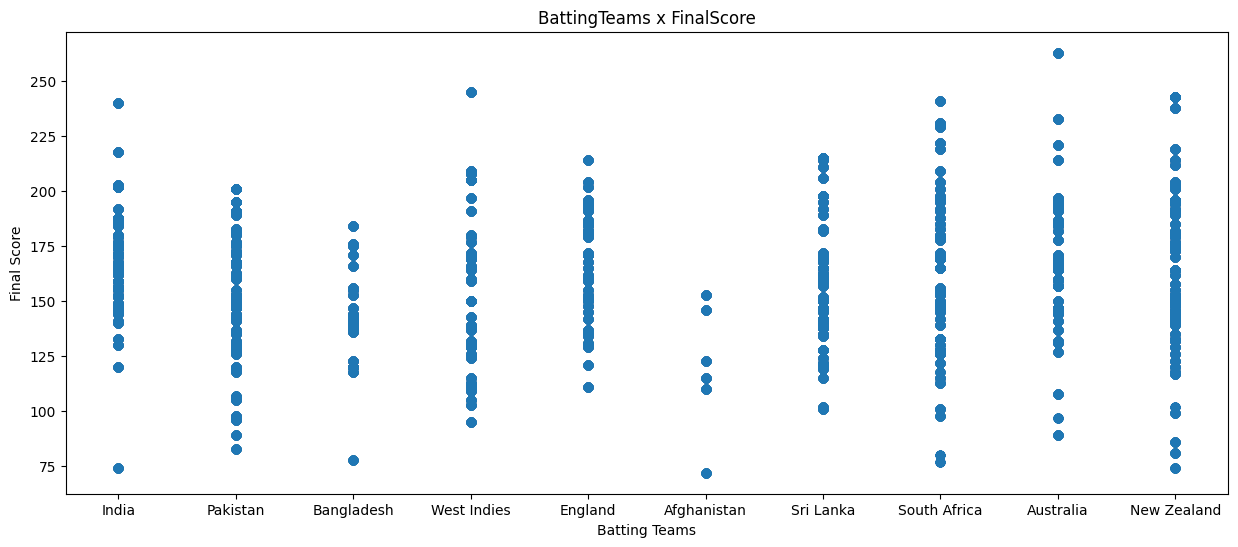

In [29]:
plt.title('BattingTeams x FinalScore')
plt.scatter(X['batting_team'],Y)
plt.xlabel('Batting Teams')
plt.ylabel('Final Score')
plt.show()

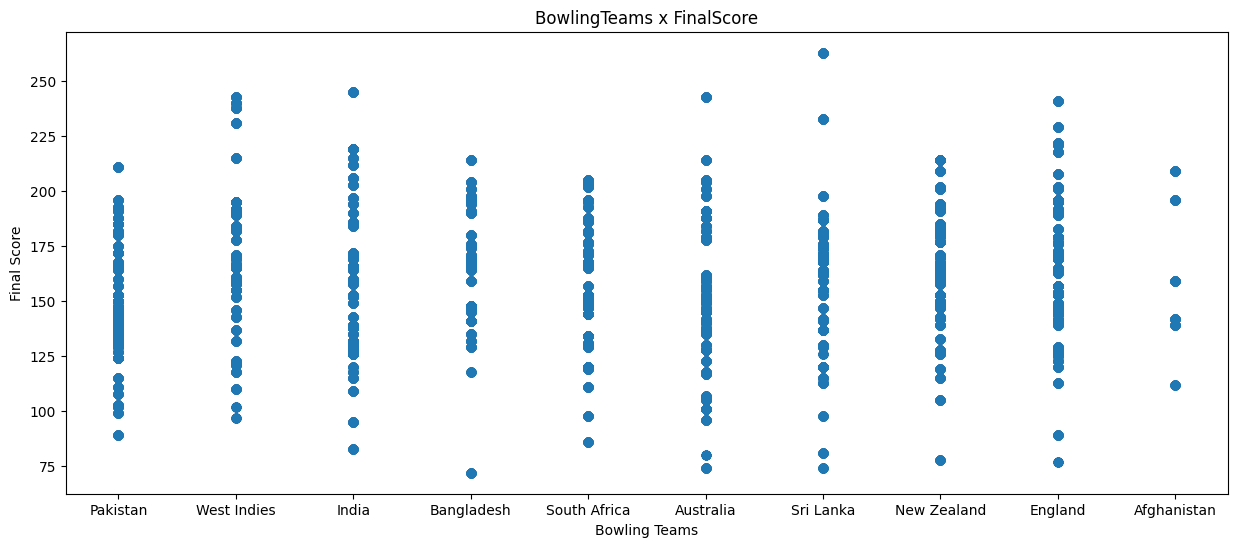

In [30]:
plt.title('BowlingTeams x FinalScore')
plt.scatter(X['bowling_team'],Y)
plt.xlabel('Bowling Teams')
plt.ylabel('Final Score')
plt.show()

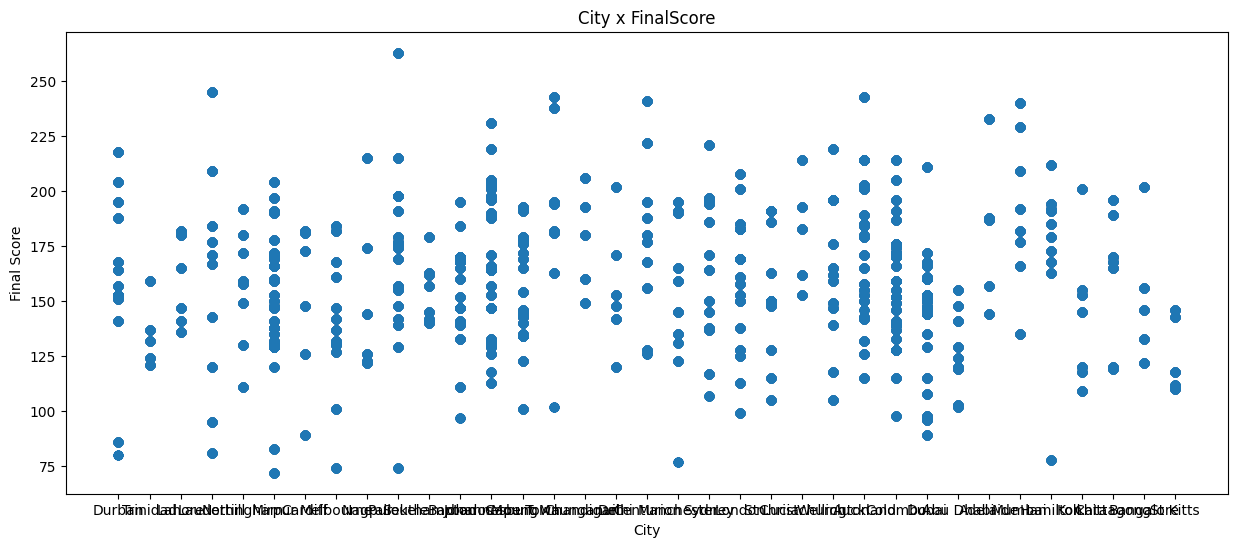

In [31]:
plt.title('City x FinalScore')
plt.scatter(X['city'],Y)
plt.xlabel('City')
plt.ylabel('Final Score')
plt.show()

In [32]:
features.corr()

<ipython-input-32-83b1bbe52583>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  features.corr()


,current_score,balls_left,wickets_left,crr,last_five,runs_x
current_score,1.000000,-0.862458,-0.385879,0.540672,0.527708,0.428561
balls_left,-0.862458,1.000000,0.666547,-0.082984,-0.194395,-0.035401
wickets_left,-0.385879,0.666547,1.000000,0.301223,0.235389,0.384102
crr,0.540672,-0.082984,0.301223,1.000000,0.767684,0.759832
last_five,0.527708,-0.194395,0.235389,0.767684,1.000000,0.614497
runs_x,0.428561,-0.035401,0.384102,0.759832,0.614497,1.000000


In [ ]:
X_train

,batting_team,bowling_team,city,current_score,balls_left,wickets_left,crr,last_five
24398,India,Australia,Adelaide,186,1,7,9.378151,52.0
46998,Pakistan,New Zealand,Auckland,54,52,5,4.764706,23.0
48930,Afghanistan,West Indies,St Kitts,57,41,3,4.329114,17.0
42165,England,New Zealand,Christchurch,171,10,6,9.327273,56.0
48423,West Indies,New Zealand,Auckland,59,53,6,5.283582,36.0
...,...,...,...,...,...,...,...,...
39749,New Zealand,India,Auckland,39,91,10,8.068966,39.0
21512,Bangladesh,India,Mirpur,58,72,8,7.250000,44.0
13422,South Africa,Australia,Sydney,143,1,4,7.210084,28.0
43832,New Zealand,India,Johannesburg,47,85,9,8.057143,39.0


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score,mean_absolute_error

In [ ]:
trf = ColumnTransformer([
    ('trf',OneHotEncoder(sparse=False,drop='first'),['batting_team','bowling_team','city'])
],remainder='passthrough')

In [ ]:
pipe = Pipeline(steps=[
    ('step1',trf),
    ('step2',StandardScaler()),
    ('step3',XGBRegressor(n_estimators=1000,learning_rate=0.2,max_depth=12,random_state=1))
])

In [ ]:
pipe.fit(X_train,Y_train)
Y_pred = pipe.predict(X_test)

print(r2_score(Y_test,Y_pred))
print(mean_absolute_error(Y_test,Y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


0.9884202798086636
1.655053564937418


In [ ]:
pickle.dump(pipe,open('/content/drive/MyDrive/pipe.pkl','wb'))

In [ ]:
pipe = pickle.load(open('/content/drive/MyDrive/pipe.pkl','rb'))

In [ ]:
# batting_team='West Indies'
# bowling_team='Pakistan'
# city = 'Dubai'
# current_score=98
# wickets = 5
# overs = 17
# last_five = 38

batting_team='India'
bowling_team='Pakistan'
city = 'Dubai'
current_score=127
wickets = 5
overs = 18
last_five = 40

In [ ]:
balls_left = 120 - (overs*6)
wickets = 10-wickets
crr = current_score / overs

In [ ]:





test_df = pd.DataFrame({'batting_team':[batting_team],'bowling_team':[bowling_team],'city':city, 'current_score':[current_score],'balls_left':[balls_left],'wickets_left':[wickets],'crr':[crr], 'last_five':[last_five]})

In [ ]:
pred_score = pipe.predict(test_df)
print(int(pred_score))

147
